In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2 as cv
from PIL import Image
import glob
import scipy

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense

labels=['can', 'plastic']

Mounted at /content/gdrive/


In [2]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', input_shape=(316, 316, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Flatten(),  
    tf.keras.layers.Dense(2, activation='softmax'),
])
model.summary()

model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 314, 314, 128)     3584      
                                                                 
 batch_normalization (BatchN  (None, 314, 314, 128)    512       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 157, 157, 128)    0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 157, 157, 128)     0         
                                                                 
 conv2d_1 (Conv2D)           (None, 155, 155, 64)      73792     
                                                                 
 batch_normalization_1 (Batc  (None, 155, 155, 64)     2

In [3]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.1
)

test_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.1
)

train_generator = train_datagen.flow_from_directory(
    '/content/gdrive/MyDrive/AIStudy/class_models/4000_data',
    target_size=(316, 316),
    batch_size=16,
    class_mode='categorical',
    subset='training',
    seed=0
)

validation_generator = test_datagen.flow_from_directory(
    '/content/gdrive/MyDrive/AIStudy/class_models/4000_data',
    target_size=(316, 316),
    batch_size=16,
    class_mode='categorical',
    subset='validation',
    seed=0
)

Found 3698 images belonging to 2 classes.
Found 410 images belonging to 2 classes.


In [ ]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('loss')<0.1):
            print("\nReached 90% accuracy so cancelling training!")
            self.model.stop_training = True

callbacks = myCallback()

In [4]:
history = model.fit_generator(train_generator, epochs=350, verbose=1, validation_data=validation_generator,  callbacks=[callbacks])

<ipython-input-4-d163000cd431>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, epochs=5, verbose=1, validation_data=validation_generator)


Epoch 1/5
232/232 [==============================] - 1156s 5s/step - loss: 0.9618 - accuracy: 0.6898 - val_loss: 0.8563 - val_accuracy: 0.5171
Epoch 2/5
232/232 [==============================] - 167s 720ms/step - loss: 0.9697 - accuracy: 0.7266 - val_loss: 1.6736 - val_accuracy: 0.5756
Epoch 3/5
232/232 [==============================] - 167s 720ms/step - loss: 0.9425 - accuracy: 0.7242 - val_loss: 0.7462 - val_accuracy: 0.7878
Epoch 4/5
232/232 [==============================] - 171s 737ms/step - loss: 0.8005 - accuracy: 0.7537 - val_loss: 0.5481 - val_accuracy: 0.8049
Epoch 5/5
232/232 [==============================] - 166s 713ms/step - loss: 0.8187 - accuracy: 0.7618 - val_loss: 0.5270 - val_accuracy: 0.7780


### 결과 확인해보기

In [5]:
avg_ac = history.history['accuracy']
avg=0
for i in range(len(avg_ac)):
  avg += avg_ac[i]
print(avg/10)

0.36560302376747134


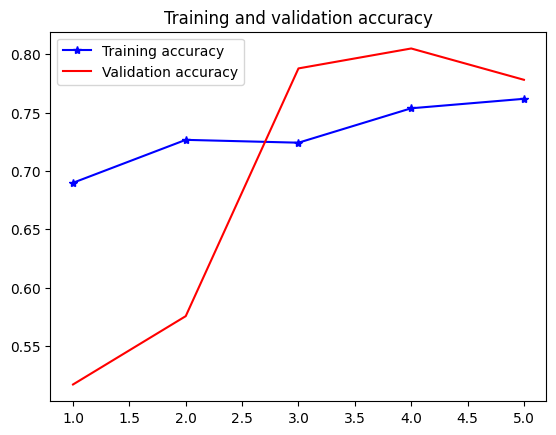

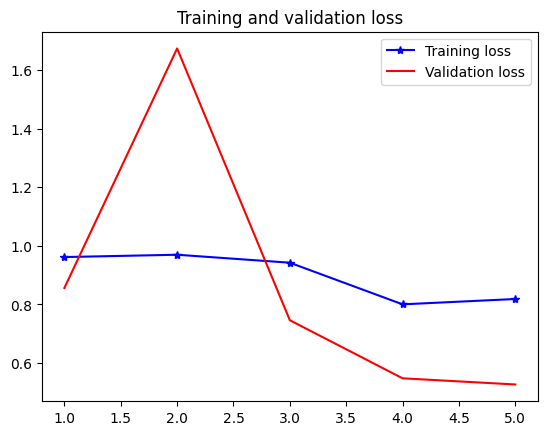

In [6]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_acc) + 1)

plt.plot(epochs, train_acc, 'b*-', label = 'Training accuracy')
plt.plot(epochs, val_acc, 'r', label = 'Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, train_loss, 'b*-', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

1/1 [==============================] - 1s 825ms/step
예측된 클래스: can


Text(0.5, 1.0, 'Actual: plastic      Pred: can')

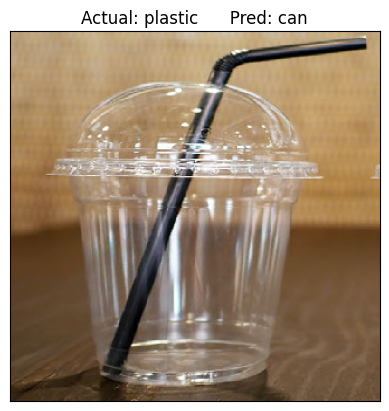

In [8]:
# 테스트할 이미지 경로
image_path = '/content/gdrive/MyDrive/AIStudy/plastic.jpg'

# 이미지 크기 조정
target_size = (316, 316)
img = image.load_img(image_path, target_size=target_size)
img2 = image.load_img(image_path, target_size=target_size)
img = image.img_to_array(img)
img = np.expand_dims(img, axis=0)
img = img / 255.0  # 이미지를 0과 1 사이의 값으로 정규화

# 예측 수행
predictions = model.predict(img)

# 예측 결과 해석
predicted_class = np.argmax(predictions[0])

class_labels = {0: 'can', 1: 'plastic'}  # 클래스 레이블과 인덱스 매핑

# 예측 결과 해석
predicted_class_index = np.argmax(predictions[0])
predicted_class_label = class_labels[predicted_class_index]

# 결과 표시
print("예측된 클래스:", predicted_class_label)

plt.imshow(img2)
plt.xticks([])
plt.yticks([])
plt.title('Actual: {}      Pred: {}'.format(labels[1], predicted_class_label))

1/1 [==============================] - 0s 41ms/step
예측된 클래스: can


Text(0.5, 1.0, 'Actual: can      Pred: can')

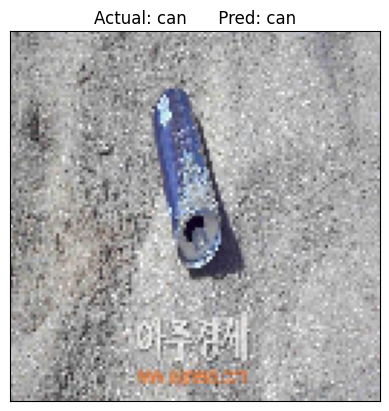

In [7]:
# 테스트할 이미지 경로
image_path = '/content/gdrive/MyDrive/AIStudy/can.jpg'

# 이미지 크기 조정
target_size = (128, 128)
img = image.load_img(image_path, target_size=target_size)
img2 = image.load_img(image_path, target_size=target_size)
img = image.img_to_array(img)
img = np.expand_dims(img, axis=0)
img = img / 255.0  # 이미지를 0과 1 사이의 값으로 정규화

# 예측 수행
predictions = model.predict(img)

# 예측 결과 해석
predicted_class = np.argmax(predictions[0])

class_labels = {0: 'can', 1: 'plastic'}  # 클래스 레이블과 인덱스 매핑

# 예측 결과 해석
predicted_class_index = np.argmax(predictions[0])
predicted_class_label = class_labels[predicted_class_index]

# 결과 표시
print("예측된 클래스:", predicted_class_label)

plt.imshow(img2)
plt.xticks([])
plt.yticks([])
plt.title('Actual: {}      Pred: {}'.format(labels[0], predicted_class_label))

### 성능 확인하기

In [9]:
test_x, test_y = validation_generator.__getitem__(1)
# test_x is used to train the data
# test_y refers to the actual answer of the testing set data
# preds refers to the predicted class
preds = model.predict(test_x)

plt.figure(figsize=(20, 20))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.title('pred:%s / truth:%s' % (labels[np.argmax(preds[i])], labels[np.argmax(test_y[i])]))
    plt.imshow(test_x[i])

Output hidden; open in https://colab.research.google.com to view.

In [10]:
print("-- Evaluate --")
scores = model.evaluate_generator(validation_generator, steps=20)
print("%s: %.2f%%" %(model.metrics_names[1], scores[1]*100))

-- Evaluate --


<ipython-input-10-0a66746c02b7>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  scores = model.evaluate_generator(validation_generator, steps=20)


accuracy: 77.81%


### 모델 저장하기

In [13]:
model.save('/content/gdrive/MyDrive/AIStudy/class_models/my_model_img316_4000.h5')

In [ ]:
with open('/content/gdrive/MyDrive/AIStudy/class_models/class_labels.txt', 'w') as file:
    file.write('\n'.join(labels))

### 모델 불러오기

In [ ]:
model = tf.keras.models.load_model('/content/gdrive/MyDrive/AIStudy/class_models/my_model.h5', compile=False)

In [12]:
test_dir = '/content/gdrive/MyDrive/AIStudy/test_img'  # 테스트 이미지 폴더 경로
target_size = (128, 128)  # 이미지 크기
test_class=[]
pred=[]
class_labels = {0: 'can', 1: 'plastic'}  # 클래스 레이블과 인덱스 매핑
i=0
for filename in os.listdir(test_dir):
    if filename.endswith('.jpg'):
        image_path = os.path.join(test_dir, filename)
        img = image.load_img(image_path, target_size=target_size)
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = img_array / 255.0  # 이미지 정규화

        # 예측 수행
        predictions = history.predict(img_array)

        # 예측 결과 해석
        predicted_class_index = np.argmax(predictions[0])
        predicted_class_label = class_labels[predicted_class_index]

        # 실제 클래스 레이블
        actual_class_label = filename.split('.')[0]
        if actual_class_label[0] == 'c' :
          test_class.append(0)
        elif actual_class_label[0] == 'p':
          test_class.append(1)

        if predicted_class_label[0] == 'c':
          pred.append(0)
        elif predicted_class_label[0] =='p':
          pred.append(1)
      
        # 결과 표시
        print('이미지:', filename)
        print('실제 클래스:', actual_class_label)
        print('예측된 클래스:', predicted_class_label)
        print()

        # 이미지와 예측 결과 표시
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
        plt.title('Actual: {}   Pred: {}'.format(actual_class_label, predicted_class_label))
        plt.show()

AttributeError: ignored

In [ ]:
from sklearn.metrics import confusion_matrix

# 테스트 데이터셋 로드
X_test = '/content/gdrive/MyDrive/AIStudy/test_img'
y_true = test_class
pred=[]
for filename in os.listdir(X_test):
    if filename.endswith('.jpg'):
        image_path = os.path.join(X_test, filename)
        img = image.load_img(image_path, target_size=target_size)
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = img_array / 255.0  # 이미지 정규화

        y_pred = model.predict(img_array)
        predicted_class_index = np.argmax(y_pred[0])
        pred.append(predicted_class_index)

#y_pred_labels = np.argmax(y_pred, axis=1)  # One-hot 인코딩된 예측값을 클래스 레이블로 변환

# 혼동 행렬 생성
cm = confusion_matrix(y_true, y_pred_labels)

# 혼동 행렬 시각화
class_names = ['can', 'plastic']  # 클래스 레이블의 이름
plt.figure(figsize=(8, 6))
plot_confusion_matrix(cm, classes=class_names, title='Confusion Matrix')

plt.show()

In [67]:
# 혼동 행렬 생성
cm = confusion_matrix(y_true, pred)

# 혼동 행렬 시각화
class_names = ['can', 'plastic']  # 클래스 레이블의 이름
plt.figure(figsize=(8, 6))
plot_confusion_matrix(cm, classes=class_names, title='Confusion Matrix')

plt.show()

ValueError: ignored

In [66]:
print(type(test_class), type(pred))
test_class = np.array(test_class)
pred = np.array(pred)
print(type(test_class), type(pred))

<class 'list'> <class 'list'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [69]:
print(test_class, pred)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
